In [14]:
# MSRRFF
import math, random, numpy as np, os, warnings, pickle, re
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Iterable, List, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib
#matplotlib.use("Agg")  # headless
import matplotlib.pyplot as plt

try:
    import pandas as pd
    PANDAS_OK = True
except Exception:
    PANDAS_OK = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42); random.seed(42)

warnings.filterwarnings("ignore")

In [5]:
data_dict = {}

# **Wind speed synthetic**

In [2]:
def safe_zscore(y: np.ndarray, X: np.ndarray, eps: float = 1e-6):
    """NaN/Inf-aware z-score with std clamping."""
    # Replace inf with NaN for stats, keep copies
    y = y.astype(float, copy=True)
    X = X.astype(float, copy=True)
    y[~np.isfinite(y)] = np.nan
    X[~np.isfinite(X)] = np.nan

    y_mu = np.nanmean(y)
    y_sd = np.nanstd(y)
    if not np.isfinite(y_mu): y_mu = 0.0
    if (not np.isfinite(y_sd)) or (y_sd < eps): y_sd = eps
    yz = (y - y_mu) / y_sd

    X_mu = np.nanmean(X, axis=0, keepdims=True)
    X_sd = np.nanstd(X, axis=0, keepdims=True)
    X_mu = np.where(np.isfinite(X_mu), X_mu, 0.0)
    X_sd = np.where((~np.isfinite(X_sd)) | (X_sd < eps), eps, X_sd)
    Xz = (X - X_mu) / X_sd

    # Final sweep to guarantee finiteness
    yz = np.nan_to_num(yz, nan=0.0, posinf=0.0, neginf=0.0)
    Xz = np.nan_to_num(Xz, nan=0.0, posinf=0.0, neginf=0.0)
    return yz, Xz, (float(y_mu), float(y_sd), X_mu.astype(float), X_sd.astype(float))

def windsynth_pp(T=24*240, test_shift=False,seed=123):
    t = np.arange(T, dtype=float)

    # base components
    np.random.seed(seed)
    diurnal   = 2.5 + 1.5*np.sin(2*np.pi*t/24 + 0.3*np.sin(2*np.pi*t/168))
    sub_daily = 0.6*np.sin(2*np.pi*t/6 + 0.5) + 0.4*np.sin(2*np.pi*t/3 + 1.3)
    weekly    = 0.8*np.sin(2*np.pi*t/168 + 0.2)
    base = diurnal + sub_daily + weekly

    # regimes
    cp1, cp2 = int(0.35*T), int(0.65*T)
    regime = np.ones(T, dtype=float)
    regime[cp1:cp2] = 1.2
    regime[cp2:]    = 0.9

    # heteroskedastic noise
    eps = 0.3*(0.5 + 0.5*np.abs(np.sin(2*np.pi*t/24))) * np.random.randn(T)

    # raw signal
    y = regime*base + eps

    # optional distribution shift
    if test_shift:
        i_va = int(0.8*T)
        t2 = np.arange(T - i_va, dtype=float)
        diurnal_shift = 2.5 + 1.8*np.sin(2*np.pi*t2/24 + 0.4*np.sin(2*np.pi*t2/168))

        seg = (y[i_va:] - diurnal[i_va:]) + diurnal_shift #+ 0.5*bursts_shift
        y[i_va:] = np.nan_to_num(seg, nan=0.0, posinf=0.0, neginf=0.0)

    # exogenous cyclical time features
    hour = (t % 24)/24.0
    week = (t % 168)/168.0
    X = np.stack([
        np.sin(2*np.pi*hour), np.cos(2*np.pi*hour),
        np.sin(2*np.pi*week), np.cos(2*np.pi*week)
    ], axis=-1)


    return y, X

class WindowDS(Dataset):
    def __init__(self, y, X, W=96, H=24, stride=1, zscore=True):
        self.y = np.nan_to_num(np.asarray(y, dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
        self.X = np.nan_to_num(np.asarray(X, dtype=float), nan=0.0, posinf=0.0, neginf=0.0)

        self.W, self.H, self.stride = int(W), int(H), int(stride)
        self.idxs = list(range(0, len(self.y)-(self.W+self.H)+1, self.stride))

        if zscore:
            self.yz, self.Xz, stats = safe_zscore(self.y, self.X, eps=1e-6)
            self.y_mu, self.y_sd, self.X_mu, self.X_sd = stats
        else:
            self.yz, self.Xz = self.y, self.X
            self.y_mu, self.y_sd = 0.0, 1.0
            self.X_mu = np.zeros((1, self.X.shape[1]), dtype=float)
            self.X_sd = np.ones((1, self.X.shape[1]), dtype=float)

        # final guarantees
        self.yz = np.nan_to_num(self.yz, 0.0, 0.0, 0.0).astype(np.float32)
        self.Xz = np.nan_to_num(self.Xz, 0.0, 0.0, 0.0).astype(np.float32)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        s = self.idxs[i]
        xin = np.concatenate([
            self.yz[s:s+self.W, None],           # (W,1)
            self.Xz[s:s+self.W, :]               # (W,4)
        ], axis=-1)
        yout = self.y[s+self.W:s+self.W+self.H]

        # safety assert (optional, helps debugging early)
        if (not np.isfinite(xin).all()) or (not np.isfinite(yout).all()):
            raise ValueError(f"Non-finite values at sample {i}, "
                             f"win [{s}:{s+self.W}], hor [{s+self.W}:{s+self.W+self.H}]")

        return torch.from_numpy(xin).float(), torch.from_numpy(yout.astype(np.float32))    

In [3]:
y, X = windsynth_pp(T=24*240, test_shift=True)
W=96
H=24
use_exog=True
use_residual=True
if not use_exog: X = np.zeros_like(X)
N = len(y); i_tr, i_va, i_te = int(0.7*N), int(0.8*N), N

ds_tr = WindowDS(y[:i_tr], X[:i_tr], W=W, H=H, stride=1, zscore=True)
tr = DataLoader(ds_tr, batch_size=128, shuffle=True, drop_last=True)
# Take one batch from the loader
x_batch, y_batch = next(iter(tr))
# x: (B, W, F), y: (B, H)
B, W, F = x_batch.shape
H = y_batch.shape[1]
print(f"Example batch -> inputs: {x_batch.shape}, outputs: {y_batch.shape}")
# The first feature in x is the (normalized) wind-speed series
wind_inputs = x_batch[:, :, 0].numpy()
wind_targets = y_batch.numpy()

Example batch -> inputs: torch.Size([128, 96, 5]), outputs: torch.Size([128, 24])


# **Wind speed real**

In [4]:
def build_data(data, x_len, y_len, gap=1):
    """
        Generates input-output pairs for multi-step time series forecasting.
        Args:
            data (np.ndarray): Array of shape (T, n_features) representing the time series.
            x_len (int): Length of the input window (number of past time steps).
            y_len (int): Length of the output window (forecast horizon).
            gap (int, optional): Number of time steps between input and output windows. Default is 1.

        Returns:
            x (np.ndarray): Array of input windows with shape (num_samples, x_len, n_features).
            y (np.ndarray): Array of output windows with shape (num_samples, y_len, n_features).

        Each sample consists of an input sequence (x) and a target sequence (y), separated by a gap.
    """
    
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y

In [11]:
raw_path = Path("../data/raw")
dataSets = list(raw_path.rglob("*.*"))

dataSets 

[PosixPath('../data/raw/Netherlands/dataset.pkl'),
 PosixPath('../data/raw/UMAPCDDA/Chengdu_Airport_China.txt'),
 PosixPath('../data/raw/UMAPCDDA/Argone_IL.txt'),
 PosixPath('../data/raw/UMAPCDDA/Beijing_Airport_China.txt')]

In [15]:
names_DB = ["Argone", "Beijing", "Chengdu", "Netherland"]


 Read data ------------------------------ 
	  dataset.pkl
1.0
(80979, 10) (80979, 10)


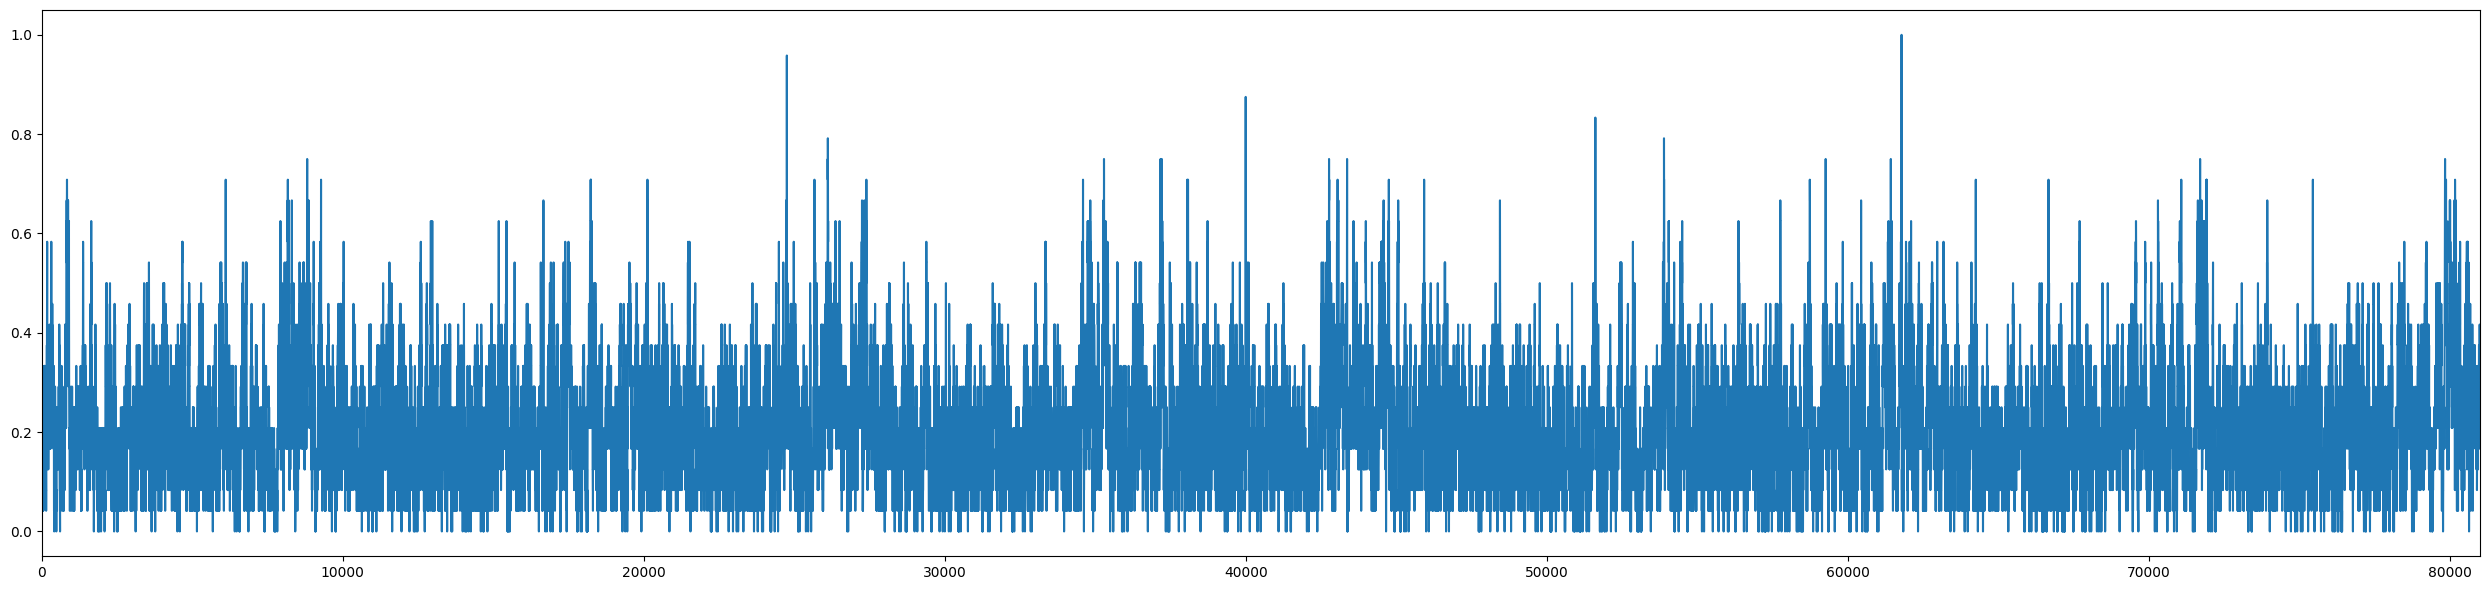

0.625
(80979, 10) (80979, 10)


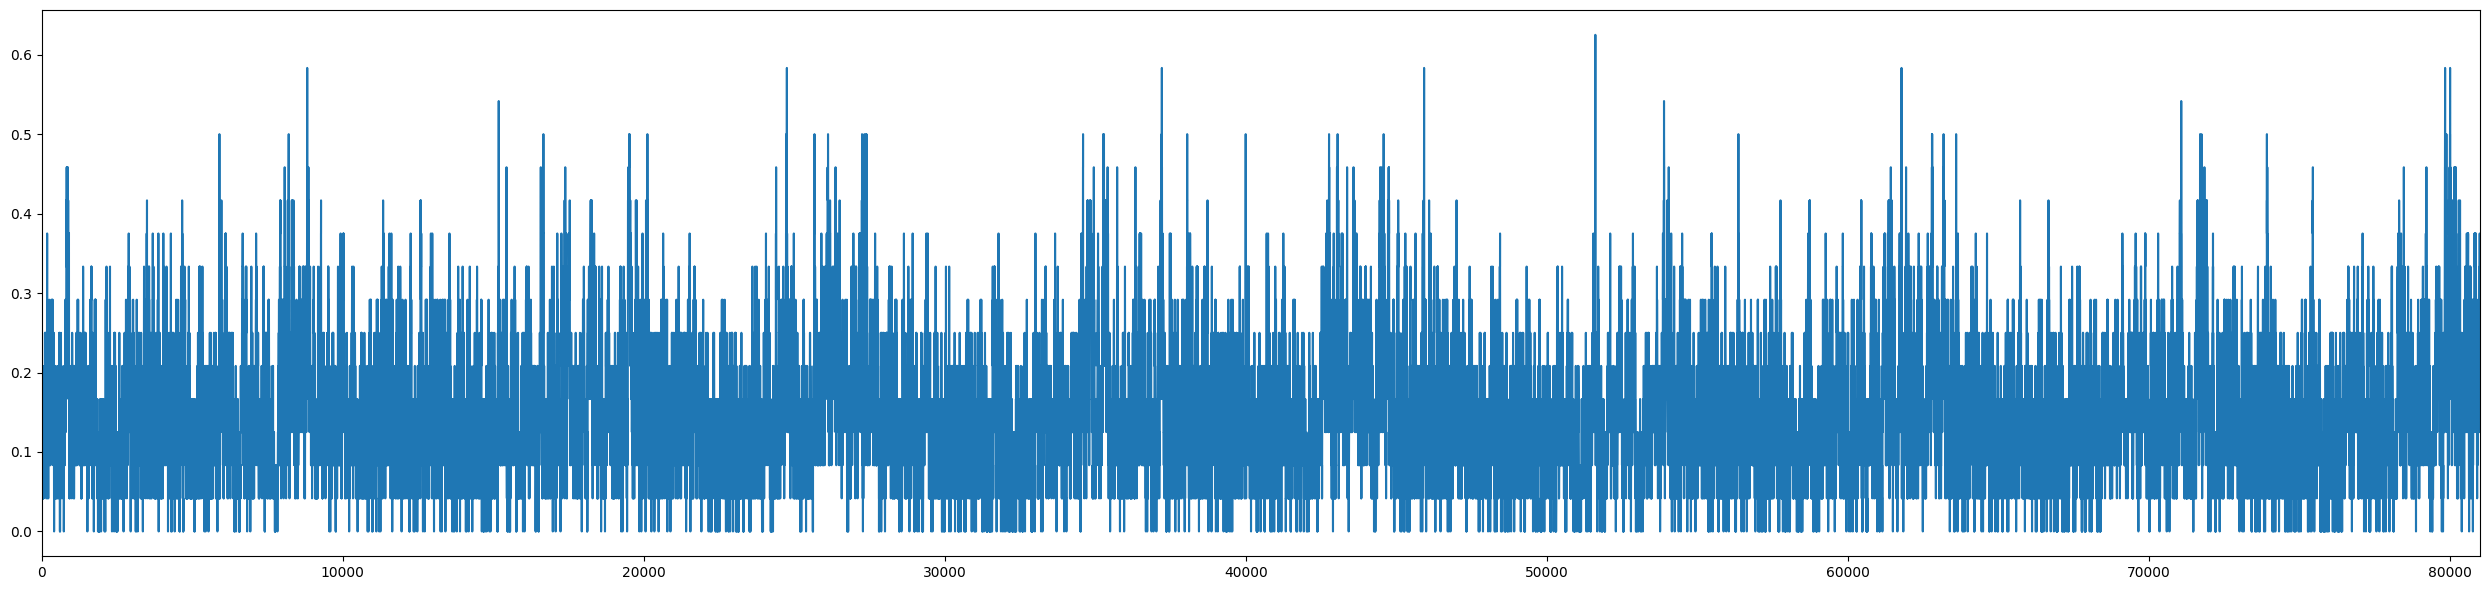

1.0
(80979, 10) (80979, 10)


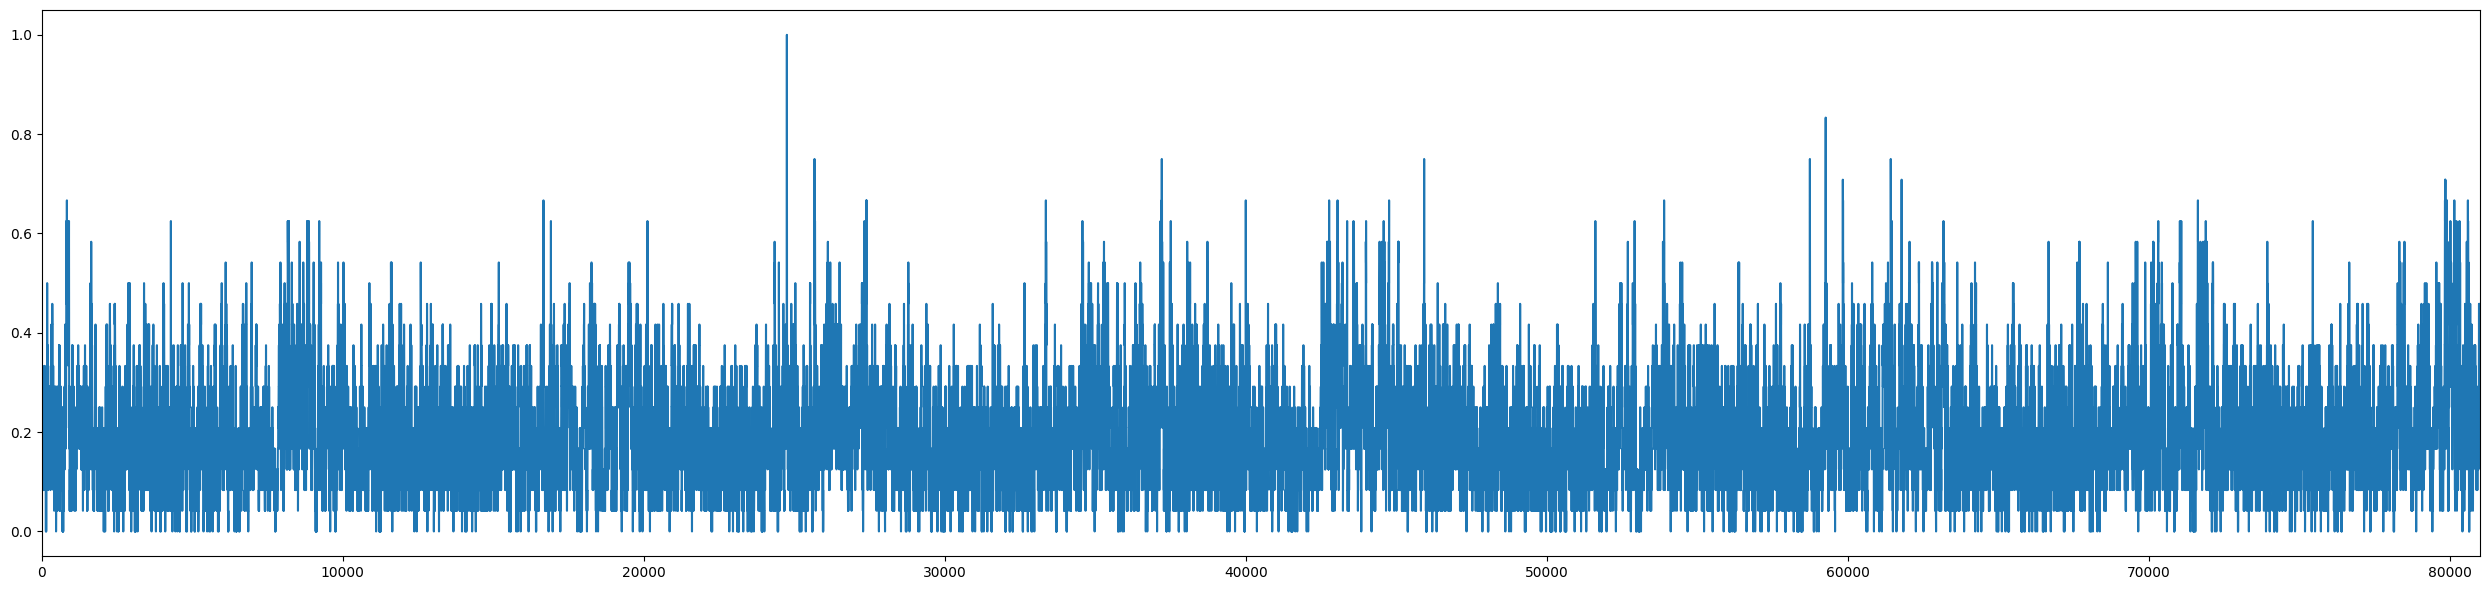


 Read data ------------------------------ 
	  Chengdu_Airport_China.txt
33.53
(69685, 20) (69685, 7)


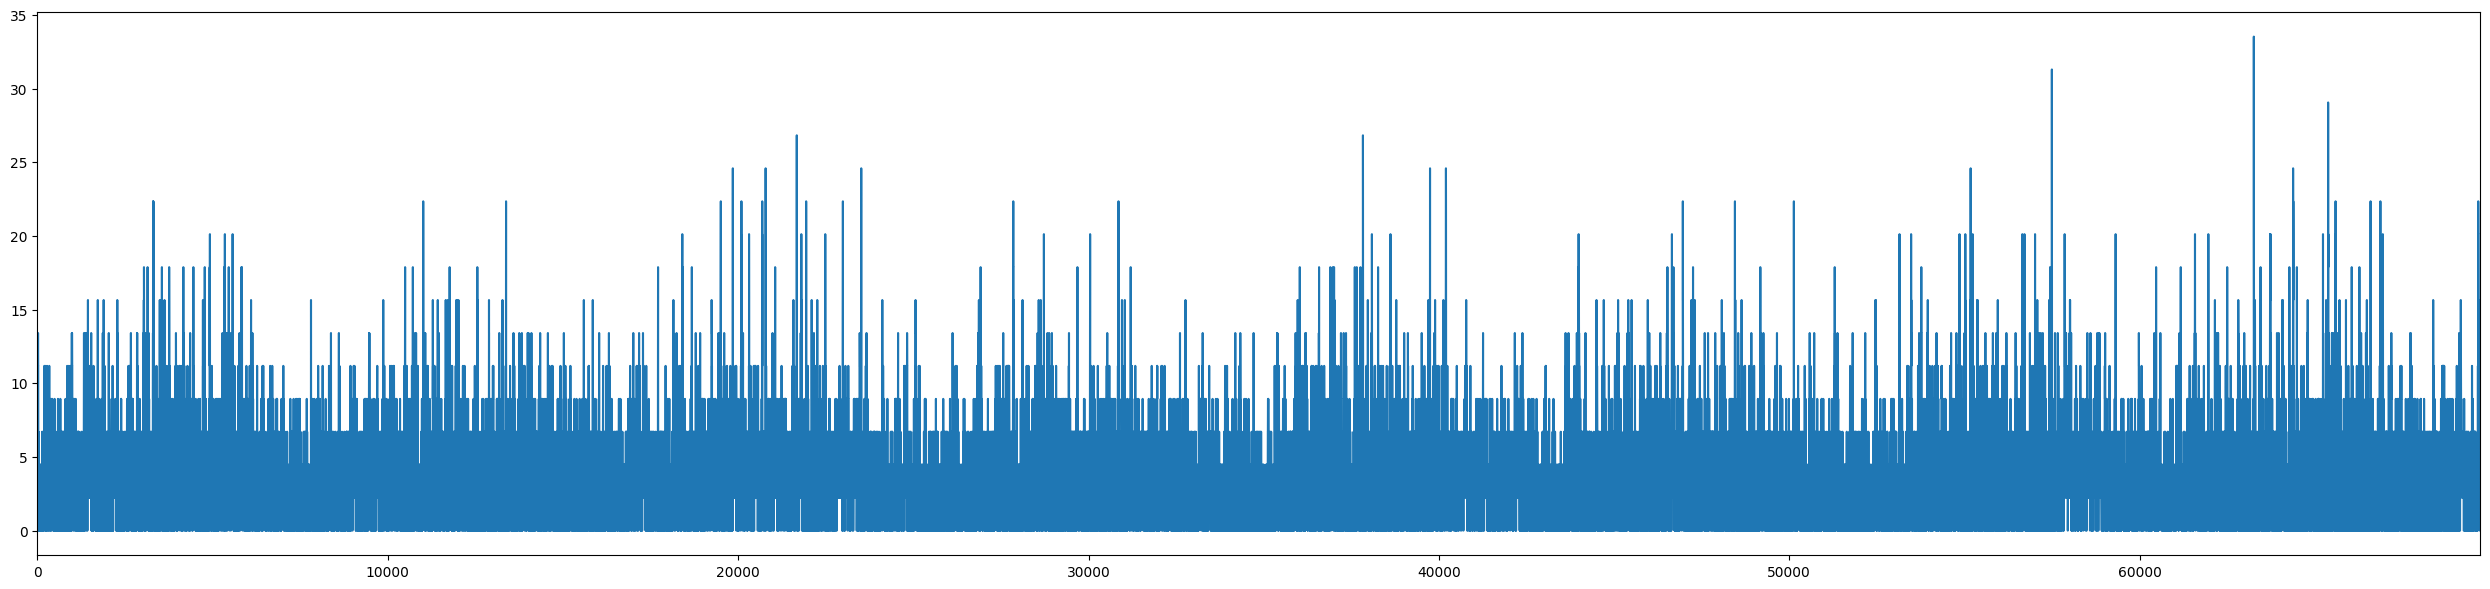


 Read data ------------------------------ 
	  Argone_IL.txt
32.44
(67892, 20) (67892, 7)


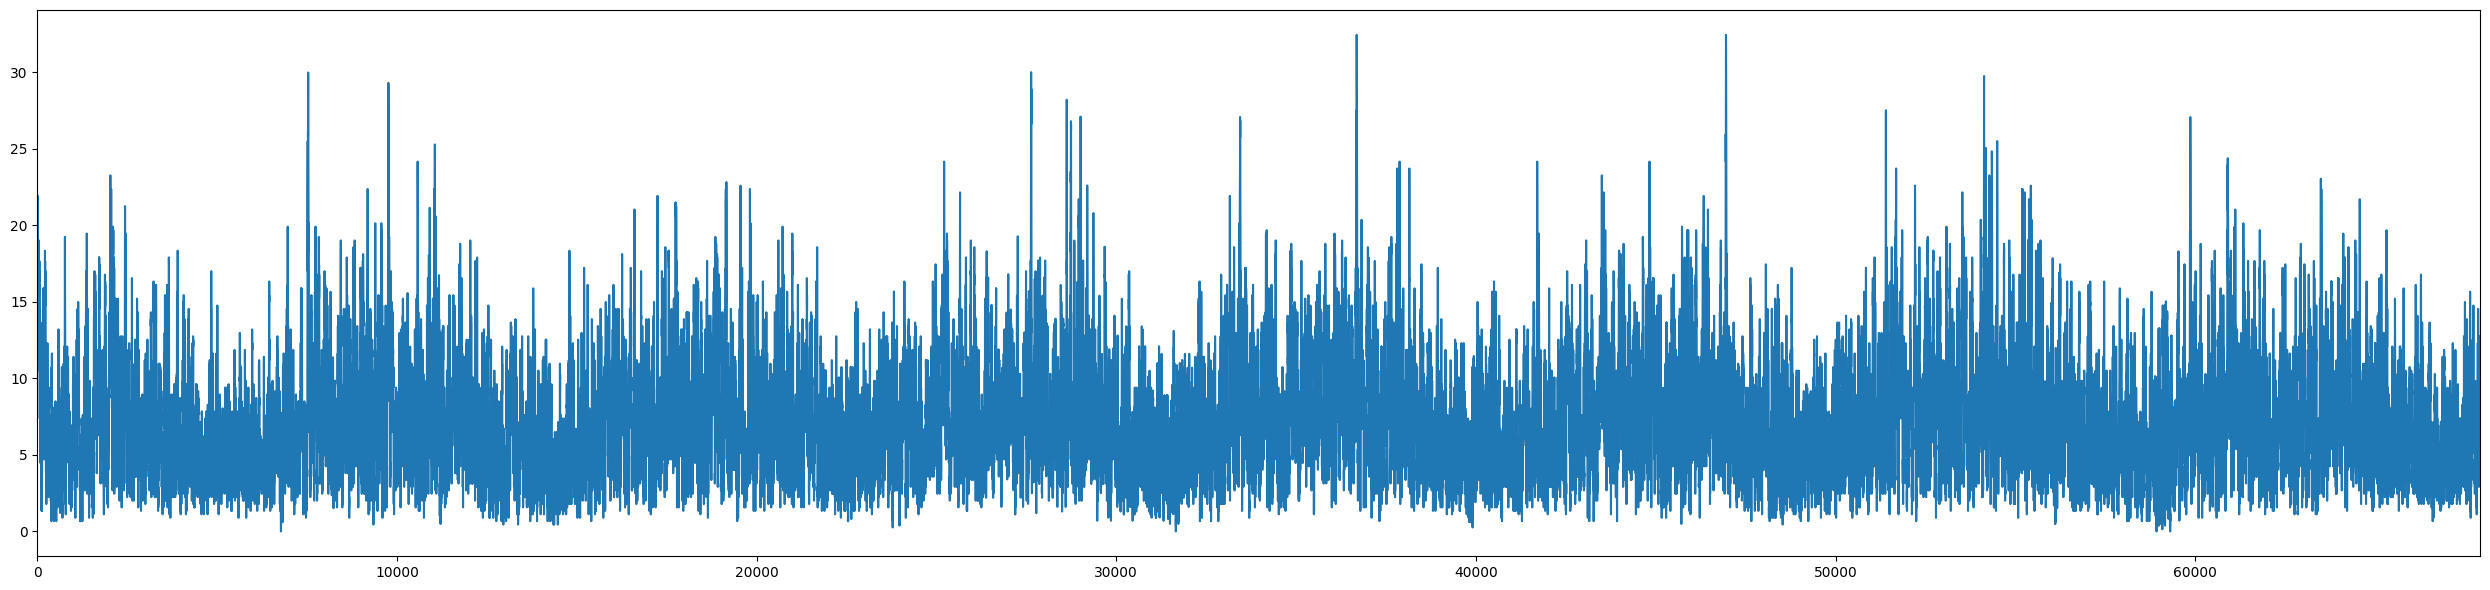


 Read data ------------------------------ 
	  Beijing_Airport_China.txt
40.235
(64964, 20) (64964, 7)


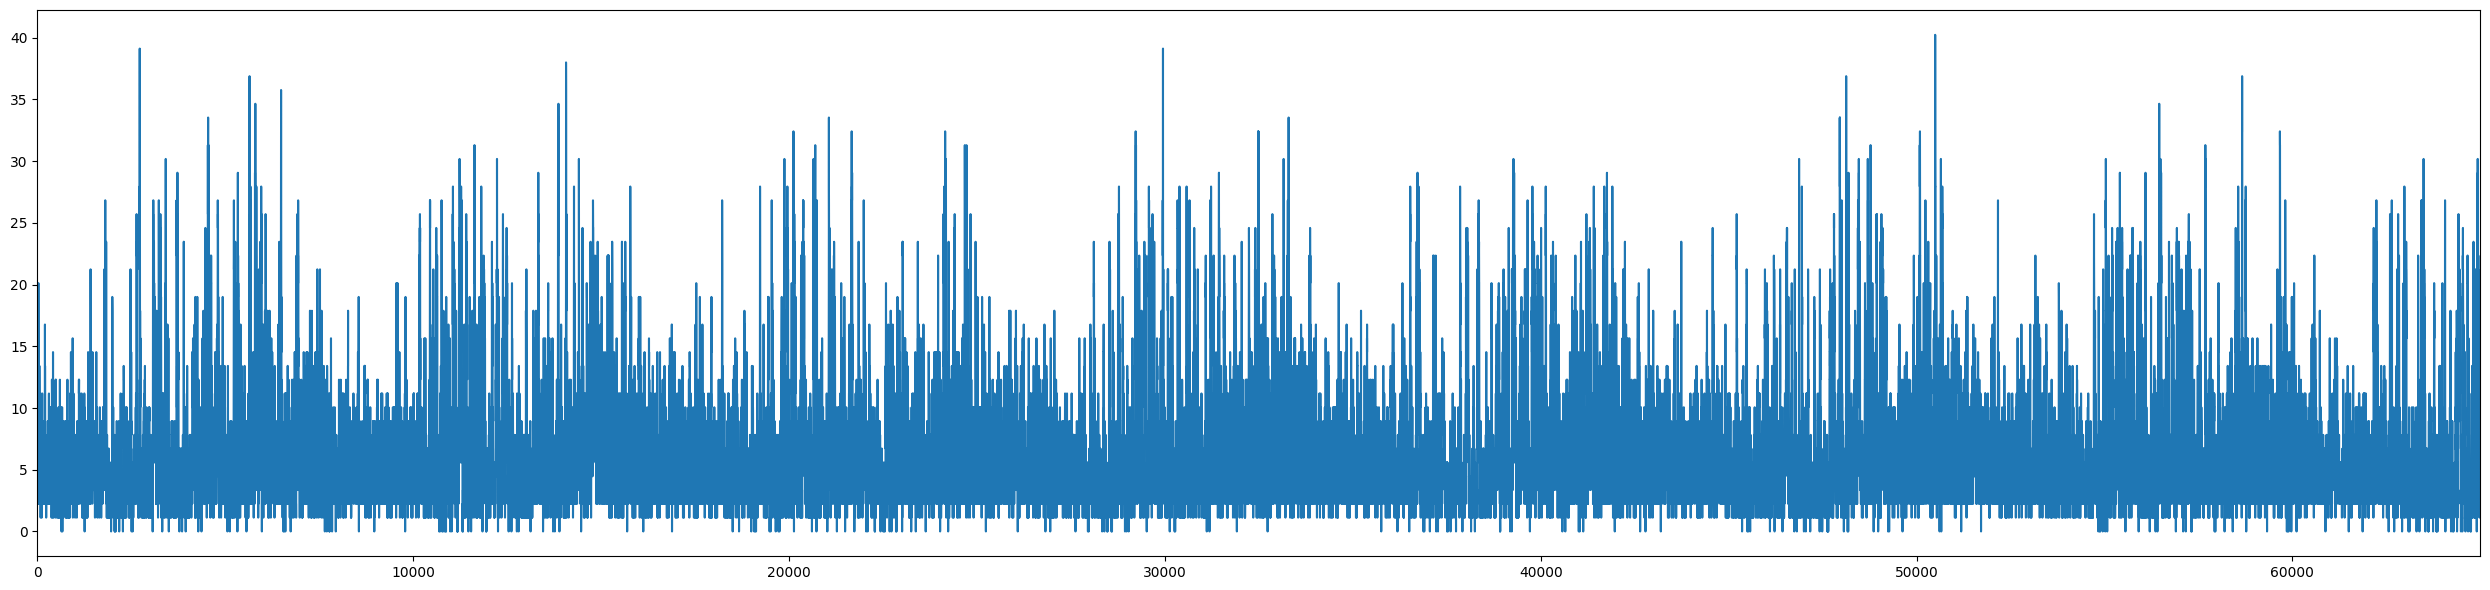

In [17]:
flag = 0 
for file_path in dataSets:
    
    # Después (usando pathlib - más limpio)
    file_names = file_path.name
    label = file_names[-3:]
    name_DB = names_DB[flag]
    flag += 1

    print(f"\n Read data ------------------------------ \n\t  {file_names}")

    if label == "csv":        
        df = pd.read_csv(file_path)
        col = None
        if 'wind_speed' in df.columns:
            col = 'wind_speed'
            tau  = 5
            tau_ = 1
        elif 'Speed' in df.columns:
            col = 'Speed'
            tau  = 15
            tau_ = 7
        else:
            continue

        values = df[col]
        n_nan = values.isnull().sum()

        max_ = max(values)
        print(max_)
        values_normalized = values/max_

        if n_nan == 0:
            X, Y = build_data(values_normalized, tau, tau_)
            fragment_to_use = values_normalized
            print(X.shape, Y.shape)
            data_dict[name_DB] = {'X': X, 'Y': Y, "time_series": values, "Max": max_}

        else:
            mask = values.notna()
            group = (mask != mask.shift()).cumsum()
            non_nan_groups = values[mask].groupby(group[mask])

            group_sizes = [(g, len(non_nan_groups.get_group(g))) for g in non_nan_groups.groups]

            if len(group_sizes) > 0:
                longest_idx, longest_segment = max(group_sizes, key=lambda x: x[1])
                values = non_nan_groups.get_group(longest_idx).to_numpy()

                if len(values) > (tau + tau_):
                    X, Y = build_data(values, tau, tau_)
                    print(X.shape, Y.shape, max_)
                    data_dict[name_DB] = {'X': X, 'Y': Y, "time_series": values, "Max": max_}
        
        plt.figure(figsize=(25, 6))
        plt.plot(values)
        plt.xlim(0, len(values))
        plt.show()

    elif label == "txt":
        tau  = 20
        tau_ = 7
        if file_names == "Argone_IL.txt":
            df = pd.read_csv(file_path, sep="\t",  names=['yyyymmdd','hhmn','mph','code'])
            df = df[df["yyyymmdd"] >= 19980101]
            df["sped"] = pd.to_numeric(df["mph"], downcast="float")
            timeSerie = df.iloc[:,2].values
        elif file_names == "Beijing_Airport_China.txt":
            df = pd.read_csv(file_path, delimiter=",")
            df["sped"] = pd.to_numeric(df["sped"], downcast="float")
            timeSerie = df.iloc[:,1].values
        elif file_names == "Chengdu_Airport_China.txt":    
            df = pd.read_csv(file_path, sep=",")
            df["sped"] = pd.to_numeric(df["sped "], downcast="float")
            timeSerie = df.iloc[:,2].values
        
        max_ = max(timeSerie)
        print(max_)
        timeSerie_normalized = timeSerie/max_
        X, Y = build_data(timeSerie_normalized, tau, tau_)
        print(X.shape, Y.shape)
        data_dict[name_DB] = {'X': X, 'Y': Y, "time_series": timeSerie, "Max": max_}

        plt.figure(figsize=(25, 6))
        plt.plot(timeSerie) 
        plt.xlim(0, timeSerie.shape[0])
        plt.tight_layout()
        plt.show()
        
    elif label == "pkl":
        tau  = 10
        tau_ = 10
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # data: Timesteps x Cities x Features        
        i_wind = 0  

        for city in range(3):
            values = np.concatenate([data['train'][:, city, i_wind], data['test'][:, city, i_wind]]) 
            max_ = max(values)

            values_normalized = values/max_

            print(max(values))
    
            X, Y = build_data(values_normalized, tau, tau_)
            print(X.shape, Y.shape)
            data_dict[f"{name_DB}-{city}"] = {'X': X, 'Y': Y, "time_series": values, "Max": max_}

            plt.figure(figsize=(25, 6))
            plt.plot(values)
            plt.xlim(0, values.shape[0])
            plt.tight_layout()
            plt.show()

In [18]:
data_dict.keys()

dict_keys(['Argone-0', 'Argone-1', 'Argone-2', 'Beijing', 'Chengdu', 'Netherland'])